In [259]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import pandas as pd
import time

## SMAB Algorithms

### Lambda-RuinAverse SMAB UCB

In [260]:
def simBandit(k, aa, nplays, b0, lam, M, arm,rseed, perotto):
    Qmat = np.zeros((nplays + 1, k))
    Obmat = np.zeros((nplays + 1, k))
    UCBmat = np.full((nplays + 1, k),1e12)
    ActionVec = np.zeros(nplays, dtype=int)
    RewardVec = np.zeros(nplays)
    budget = np.zeros(nplays + 1)
    budget[0] = b0
    isRuined = False
    np.random.seed(rseed)
    
    for tt in range(nplays):
        #Selecting Optimal Action and Observing Rewards
        ActionVec[tt] = np.random.choice(np.flatnonzero(Obmat[tt,:] == Obmat[tt,:].max())) + 1
        RewardVec[tt] = arm(ActionVec[tt])
        if budget[tt] + RewardVec[tt] < 0:
            isRuined = True
            return Qmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, (tt + 1)
        budget[tt + 1] = budget[tt] + RewardVec[tt]
        past_rewards = RewardVec[:tt+1] 
        past_actions = ActionVec[:tt+1]
        UCBvalue = tt + 1

        #Perotto Term switch
        if perotto == True:
            UCBvalue = budget[tt+1] + 1

        #Bootstrapped Action Values
        remaining_plays = nplays - (tt + 1)
        if remaining_plays > 0:
            for a in range(1,k+1):
                SetRewards = past_rewards[past_actions == a]
                if len(SetRewards) != 0:
                    bootStrapRewards = np.random.choice(SetRewards, size=(M, remaining_plays), replace=True)
                    cum_rewards = np.cumsum(bootStrapRewards, axis=1)
                    ruin_samples = np.any(cum_rewards + budget[tt + 1] <= 0, axis=1)
                    Qmat[tt + 1, a-1] = ((-budget[tt + 1] - lam)*sum(ruin_samples) + np.sum(cum_rewards[:,remaining_plays-1][~ruin_samples]))/M
                    UCBmat[tt + 1, a-1] = np.sqrt(aa * np.log(UCBvalue)) / max(1, np.sum(past_actions == a))
        Obmat[tt + 1,:] = Qmat[tt + 1,:]+ UCBmat[tt + 1,:] #####(nplays+1 - tt)
    return Qmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, nplays+1

### Action Value MAB UCB

In [261]:
def simBanditMAB(k, aa, nplays, b0, lam, M, arm,rseed, perotto):
    # Initialize matrices and vectors
    Qmat = np.zeros((nplays + 1, k))
    Pmat = np.zeros((nplays + 1, k))
    Obmat = np.zeros((nplays + 1, k))
    UCBmat = np.full((nplays + 1, k),1e12)
    ActionVec = np.zeros(nplays, dtype=int)
    RewardVec = np.zeros(nplays) #we can think of Rewards starting only at time 1
    budget = np.zeros(nplays + 1)
    budget[0] = b0
    isRuined = False
    np.random.seed(rseed)
    
    for tt in range(nplays):
        ActionVec[tt] = np.random.choice(np.flatnonzero(Obmat[tt,:] == Obmat[tt,:].max())) + 1
        #ActionVec[tt] = np.random.choice(np.arange(1,k+1)) #the random policy

        RewardVec[tt] = arm(ActionVec[tt])
        # Update budget
        if budget[tt] + RewardVec[tt] < 0:
            isRuined = True
            return Qmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, (tt + 1)
        budget[tt + 1] = budget[tt] + RewardVec[tt]
        
        # Carry forward Q-values and ruin probabilities for non-selected actions
        Qmat[tt + 1, :] = Qmat[tt, :]

        # Update Q-value for the selected action
        past_rewards = RewardVec[:tt+1] ## excluses the t+1 th element
        past_actions = ActionVec[:tt+1]
        Qmat[tt + 1, ActionVec[tt] - 1] = np.mean(past_rewards[past_actions == ActionVec[tt]])
        UCBvalue = tt + 1

        if perotto == True:
            UCBvalue = budget[tt+1] + 1

        # Calculate ruin probabilities using bootstrap
        remaining_plays = nplays - (tt + 1)
        if remaining_plays > 0:
            for a in range(1,k+1):
                ruin_samples = np.zeros(M, dtype=bool)
                SetRewards = past_rewards[past_actions == a]
                if len(SetRewards) != 0:
                    bootStrapRewards = np.random.choice(SetRewards, size=(M, remaining_plays), replace=True)
                    cum_rewards = np.cumsum(bootStrapRewards, axis=1)
                    ruin_samples = np.any(cum_rewards + budget[tt + 1] < 0, axis=1)
                    Pmat[tt + 1, a-1] = np.mean(ruin_samples)
                    UCBmat[tt + 1, a-1] = np.sqrt(aa * np.log(UCBvalue)) / max(1, np.sum(past_actions == a))
        Obmat[tt + 1,:] = Qmat[tt + 1,:] - lam * Pmat[tt + 1,:] + UCBmat[tt + 1,:]  #####(nplays+1 - tt)
    return Qmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, nplays+1

## Eight Normal Arms

In [262]:
def armNorm(x):
    return(np.random.normal(muvec[x-1],sigvec[x-1]))

In [263]:
nplays = 500
aa = 10
b0 = 0.5
M = 100
cons = 0.1

np.random.seed(12345)
muvec =  np.random.uniform(-0.01,0.01 ,size = 8)
sigvec =  np.random.gamma(shape = 1, scale = 0.1,size = 8)
k = len(muvec)

print(muvec)
print(sigvec)


[ 0.00859232 -0.00367249 -0.00632162 -0.00590879  0.0013545   0.00191089
  0.00929029  0.00306354]
[0.13819304 0.10600741 0.13771951 0.32520898 0.00084237 0.01125467
 0.03548248 0.10683096]


In [264]:
lamVec = np.array([0,1,10,100])
descrList = [f"MAB UCB",f"RuinAverse with lam = {lamVec[0]}",f"RuinAverse with lam = {lamVec[1]}",f"RuinAverse with lam = {lamVec[2]}",f"RuinAverse with lam= {lamVec[3]}",
            f"MAB UCBBudget",f"RuinAverse UCBBudget with lam  = {lamVec[0]}",f"RuinAverse UCBBudget with lam = {lamVec[1]}",f"RuinAverse UCBBudget with lam = {lamVec[2]}",f"RuinAverse UCBBudget with lam = {lamVec[3]}"]
descrList

['MAB UCB',
 'RuinAverse with lam = 0',
 'RuinAverse with lam = 1',
 'RuinAverse with lam = 10',
 'RuinAverse with lam= 100',
 'MAB UCBBudget',
 'RuinAverse UCBBudget with lam  = 0',
 'RuinAverse UCBBudget with lam = 1',
 'RuinAverse UCBBudget with lam = 10',
 'RuinAverse UCBBudget with lam = 100']

# Simulated Episodes

In [266]:
trials = 1000
seedoffset = 321
lamVec = np.array([0,0,1,10,100])
resultsMat = [[0]*10,[0]*10]
for i in range(10):
    resultsMat[0][i] = np.zeros(trials)
    resultsMat[1][i] = np.zeros((trials,nplays+1))

for i in range(trials):
    start = time.time()

    for j in range(10):
        lamIndex = j%5
        if lamIndex == 0:
            Qmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin = simBanditMAB(k, aa, nplays, b0, lamVec[lamIndex], M, armNorm,i+seedoffset,j>4)
            resultsMat[0][j][i] = timeRuin
            resultsMat[1][j][i,:] = budget
        else:
            Qmat, Obmat, UCBmat, ActionVec, RewardVec, budget, isRuined, timeRuin = simBandit(k, aa, nplays, b0, lamVec[lamIndex], M, armNorm,i+seedoffset,j>4)
            resultsMat[0][j][i] = timeRuin
            resultsMat[1][j][i,:] = budget

    end = time.time()
    print(f'The {i+1}-th iteration took {end-start:1f} to run')

The 1-th iteration took 2.579478 to run
The 2-th iteration took 10.146442 to run
The 3-th iteration took 0.028423 to run
The 4-th iteration took 7.201384 to run
The 5-th iteration took 9.204512 to run
The 6-th iteration took 8.678994 to run
The 7-th iteration took 4.819760 to run
The 8-th iteration took 7.201174 to run
The 9-th iteration took 0.019848 to run
The 10-th iteration took 7.399420 to run
The 11-th iteration took 0.086480 to run
The 12-th iteration took 6.972420 to run
The 13-th iteration took 6.605551 to run
The 14-th iteration took 10.652031 to run
The 15-th iteration took 8.686080 to run
The 16-th iteration took 7.912190 to run
The 17-th iteration took 5.960911 to run
The 18-th iteration took 8.605107 to run
The 19-th iteration took 9.547531 to run
The 20-th iteration took 0.087660 to run
The 21-th iteration took 8.210185 to run
The 22-th iteration took 8.437968 to run
The 23-th iteration took 11.557983 to run
The 24-th iteration took 8.062346 to run
The 25-th iteration to

In [267]:
survivalProb = np.zeros(10)
averageBudget = np.zeros(10)
for j in range(10): 
    survivalProb[j] = sum(resultsMat[0][j] == (nplays + 1)) / trials
    averageBudget[j] = np.mean(resultsMat[1][j][:,500])


# Results

### Final Stage Metrics

In [268]:
pd.DataFrame(np.transpose(np.array([survivalProb,averageBudget])),descList,columns = ["Survival Probability", "Average Budget"])

,Survival Probability,Average Budget
MAB with lamVec = 0,0.195,0.808703
SMAB with lamVec = 0,0.346,1.491582
SMAB with lamVec = 1,0.427,1.620924
SMAB with lamVec = 10,0.697,1.714504
SMAB with lamVec = 100,0.736,1.838440
MAB-UCB with lamVec = 0,0.204,0.792171
SMAB-UCB with lamVec = 0,0.381,1.607268
SMAB-UCB with lamVec = 1,0.624,1.766648
SMAB-UCB with lamVec = 10,0.713,1.684592
SMAB-UCB with lamVec = 100,0.733,1.800456


In [269]:
survList = [0]*10
for j in range(10):
    survList[j] = np.zeros(nplays + 1)
    
for j in range(10):
    for i in range(nplays+1):
        survList[j][i] = sum(resultsMat[0][j] >= (i+1))/len(resultsMat[0][j])

### Metrics over Stages

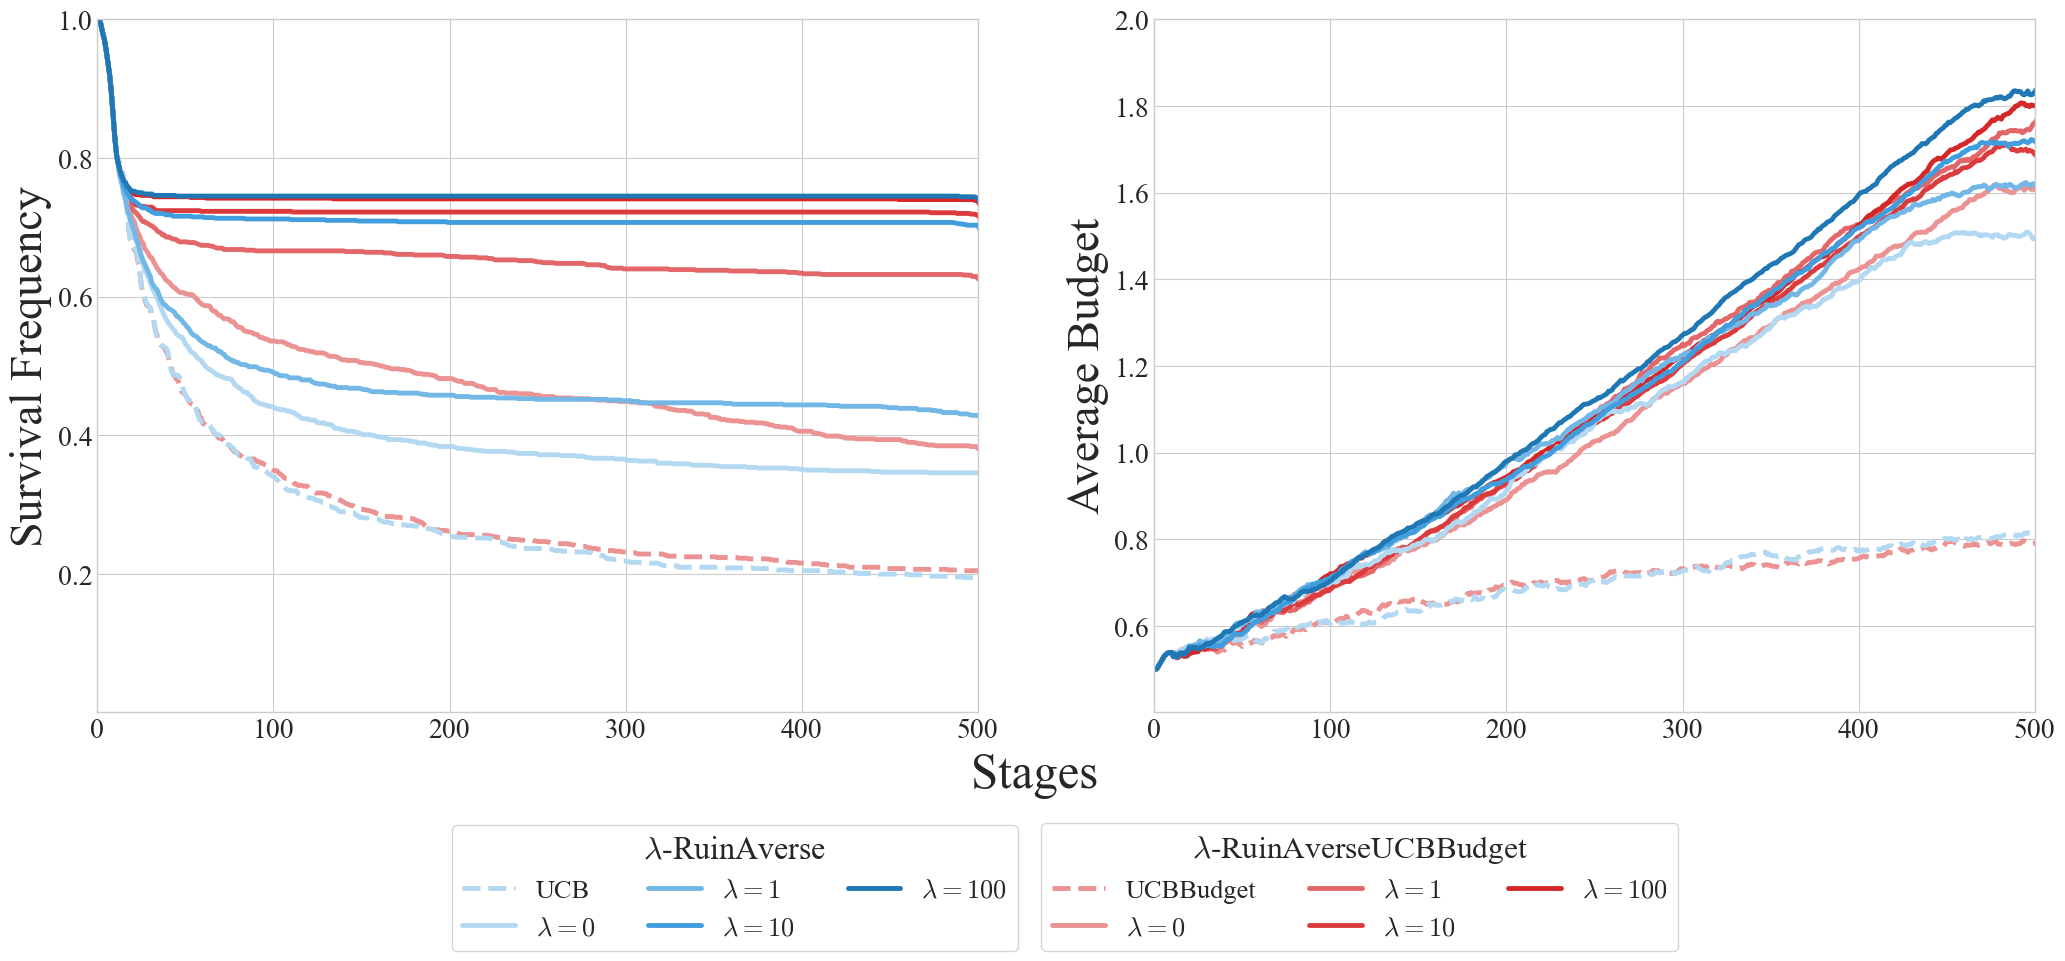

In [273]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # or 'Georgia', etc.
plt.rcParams['mathtext.fontset'] = 'cm'

# Create the plot

fig, ax = plt.subplots(1, 2, figsize=(25, 9))
plt.style.use('seaborn-v0_8-whitegrid')
x = range(1, nplays + 2)
linewidth = 3.5
line6, = ax[0].plot(x, survList[5], color=lighten_color('C3', 0.5), linestyle='--', label='UCBBudget', lw=linewidth)
line7, = ax[0].plot(x, survList[6], color=lighten_color('C3', 0.5), linestyle='-', label=fr'$\lambda = 0$', lw=linewidth)
line8, = ax[0].plot(x, survList[7], color=lighten_color('C3', 0.7), linestyle='-', label=fr'$\lambda = {lam1}$', lw=linewidth)
line9, = ax[0].plot(x, survList[8], color = lighten_color('C3', 0.9), linestyle='-', label=fr'$\lambda = {lam2}$', lw=linewidth)
line10, = ax[0].plot(x, survList[9], color='C3', linestyle='-', label=fr'$\lambda = {lam3}$', lw=linewidth)

line1, = ax[0].plot(x, survList[0], color=lighten_color('C0', 0.3), linestyle='--', label=fr'UCB', lw=linewidth)
line2, = ax[0].plot(x, survList[1], color=lighten_color('C0', 0.3), linestyle='-', label=fr'$\lambda = 0$', lw=linewidth)
line3, = ax[0].plot(x, survList[2], color=lighten_color('C0', 0.55), linestyle='-', label=fr'$\lambda = {lam1}$', lw=linewidth)
line4, = ax[0].plot(x, survList[3], color=lighten_color('C0', 0.75), linestyle='-', label=fr'$\lambda = {lam2}$', lw=linewidth)
line5, = ax[0].plot(x, survList[4], color='C0', linestyle='-', label=fr'$\lambda = {lam3}$', lw=linewidth)


xticks = np.array([0,100,200,300,400,500])
y1ticks = np.array([0,0.2,0.4,0.6,0.8,1])
ax[0].set_ylabel('Survival Frequency', fontsize = 33)
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xticks, fontsize = 20)
ax[0].set_yticks(y1ticks)
ax[0].set_yticklabels(y1ticks, fontsize = 20)


ax[0].set_ylim(0.001, 1)
ax[0].set_xlim(0, 500)

# Plot 2: Average Budget
ax[1].plot(range(1, nplays + 2), np.mean(resultsMat[1][5], axis=0), color=lighten_color('C3', 0.5), linestyle='--', label='Perotto', lw=linewidth)
ax[1].plot(range(1, nplays + 2), np.mean(resultsMat[1][6], axis=0), color=lighten_color('C3', 0.5), linestyle='-', label=fr'Perotto $\lambda$ = {lamVec[0]}', lw=linewidth)
ax[1].plot(range(1, nplays + 2), np.mean(resultsMat[1][7], axis=0), color=lighten_color('C3', 0.7), linestyle='-', label=fr'Perotto $\lambda$ = {lamVec[2]}', lw=linewidth)
ax[1].plot(range(1, nplays + 2), np.mean(resultsMat[1][8], axis=0), color=lighten_color('C3', 0.9), linestyle='-', label=fr'Perotto $\lambda$ = {lamVec[3]}', lw=linewidth)
ax[1].plot(range(1, nplays + 2), np.mean(resultsMat[1][9], axis=0), color='C3', linestyle='-', label=fr'Perotto $\lambda$ = {lamVec[4]}', lw=linewidth)


ax[1].plot(range(1, nplays + 2), np.mean(resultsMat[1][0], axis=0), color=lighten_color('C0', 0.3), linestyle='--', label=fr'UCB', lw=linewidth)
ax[1].plot(range(1, nplays + 2), np.mean(resultsMat[1][1], axis=0), color=lighten_color('C0', 0.3), linestyle='-', label=fr'$\lambda$ = {lamVec[0]}', lw=linewidth)
ax[1].plot(range(1, nplays + 2), np.mean(resultsMat[1][2], axis=0), color=lighten_color('C0', 0.55), linestyle='-', label=fr'$\lambda$ = {lamVec[2]}', lw=linewidth)
ax[1].plot(range(1, nplays + 2), np.mean(resultsMat[1][3], axis=0), color=lighten_color('C0', 0.75), linestyle='-', label=fr'RuinAverse $\lambda$ = {lamVec[3]}', lw=linewidth)
ax[1].plot(range(1, nplays + 2), np.mean(resultsMat[1][4], axis=0), color='C0', linestyle='-', label=fr'RuinAverse$\lambda$= {lamVec[4]}', lw=linewidth)


y2ticks = np.array([0,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2])

ax[1].set_xlim(0, 500)
ax[1].set_ylabel('Average Budget',fontsize = 33)
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(xticks, fontsize = 20)

ax[1].set_yticks(y2ticks)
ax[1].set_yticklabels(y2ticks, fontsize = 20)

ax[1].set_ylim(0.401, 2)


# Add a global legend for the first subplot only
lines_legend1 = [line1, line2, line3, line4, line5]
labels_legend1 = [line1.get_label(), line2.get_label(), line3.get_label(), line4.get_label(), line5.get_label()]

lines_legend2 = [line6, line7, line8, line9, line10]
labels_legend2 = [line6.get_label(), line7.get_label(), line8.get_label(), line9.get_label(), line10.get_label()]

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # or 'Georgia', etc.
plt.rcParams['mathtext.fontset'] = 'cm'
fig.legend(lines_legend1, labels_legend1, loc='lower center', bbox_to_anchor=(0.38, -0.17), ncol=3, title = fr'$\lambda$-RuinAverse', title_fontsize = 23, fontsize=19, frameon = True)
fig.legend(lines_legend2, labels_legend2, loc='lower center', bbox_to_anchor=(0.63, -0.17), ncol=3, title = fr'$\lambda$-RuinAverseUCBBudget', title_fontsize = 22.6, fontsize=19, frameon = True)

fig.text(0.5, 0.04, 'Stages', ha='center', va='center', fontsize=35)
#fig.legend(lines_first_subplot, labels_first_subplot, loc='lower center',bbox_to_anchor = (0.5,-0.13), ncol = 5, prop={'size': 22})

plt.show()